## Creating plastic synapses with NESTML

In [1]:
import nest  # import NEST module
import matplotlib.pyplot as plt  # for plotting
from pynestml.frontend.pynestml_frontend import generate_nest_target  # NESTML
import numpy


              -- N E S T --
  Copyright (C) 2004 The NEST Initiative

 Version: 3.7.0
 Built: Oct 17 2024 06:44:00

 This program is provided AS IS and comes with
 NO WARRANTY. See the file LICENSE for details.

 Problems or suggestions?
   Visit https://www.nest-simulator.org

 Type 'nest.help()' to find out more about NEST.



<img src="images/stdp.png" alt="Drawing" style="width: 500px;"/>


Asymmetric STDP learning window. Spike-timing window of STDP for the induction of synaptic potentiation and depression characterized in hippocampal cultures. Data points from Bi and Poo (1998) [18], represent the relative change in the amplitude of EPSC after repetitive correlated activity of pre-post spike pairs. The LTP (+) and LTD (-) windows are fitted by the exponential function ∆g = A ± exp(−|∆t|/τ), with parameters A + = 0.86, A − = −0.25, τ + = 19 ms, and τ − = 34 ms. Adopted from Bi and Wang (2002).

Here we will use a power-law based formulation as described in Morrison, A., Aertsen, A., & Diesmann, M. (2007). Spike-timing-dependent plasticity in balanced random networks. Neural computation, 19(6), 1437-1467.

<img src="images/stdp_eq.png" alt="Drawing" style="width: 500px;"/>

In [2]:
generate_nest_target(
    input_path=[
        "models/iaf_psc_exp.nestml",
        "models/stdp_pl_synapse.nestml",
    ],
    target_path="./targets",
    install_path='.',
    logging_level="ERROR",
    suffix="_nestml",
    codegen_opts={
        "neuron_synapse_pairs": [
            {
                "neuron": "iaf_psc_exp",
                "synapse": "stdp_pl",
                "post_ports": ["post_spikes"],
            }
        ]
    },
)


              -- N E S T --
  Copyright (C) 2004 The NEST Initiative

 Version: 3.7.0
 Built: Oct 17 2024 06:44:00

 This program is provided AS IS and comes with
 NO WARRANTY. See the file LICENSE for details.

 Problems or suggestions?
   Visit https://www.nest-simulator.org

 Type 'nest.help()' to find out more about NEST.

CMake Warning (dev) at CMakeLists.txt:95 (project):
  cmake_minimum_required() should be called prior to this top-level project()
  call.  Please see the cmake-commands(7) manual for usage documentation of
  both commands.
This warning is for project developers.  Use -Wno-dev to suppress it.

-- The CXX compiler identification is GNU 14.1.1
-- Detecting CXX compiler ABI info
-- Detecting CXX compiler ABI info - done
-- Check for working CXX compiler: /usr/bin/c++ - skipped
-- Detecting CXX compile features
-- Detecting CXX compile features - done

-------------------------------------------------------
nestmlmodule Configuration Summary
-------------------------


Oct 17 09:03:13 Install [Info]: 
    loaded module nestmlmodule

Oct 17 09:03:13 NodeManager::prepare_nodes [Info]: 
    Preparing 5 nodes for simulation.

Oct 17 09:03:13 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 5
    Simulation time (ms): 1400
    Number of OpenMP threads: 1
    Not using MPI

Oct 17 09:03:13 SimulationManager::run [Info]: 
    Simulation finished.


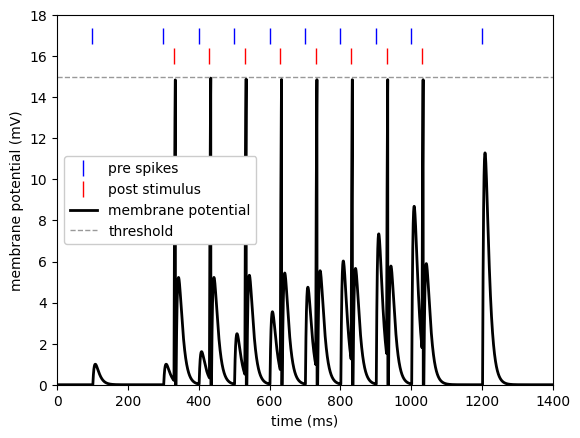

In [3]:
nest.ResetKernel()  # reset simulation kernel

# install resulting NESTML module to make models available in NEST
nest.Install("nestmlmodule")

# after this, the following two models are available in NEST
# neuron_model_name = "iaf_psc_exp_nestml__with_stdp_pl_nestml"
# synapse_model_name = "stdp_pl_nestml__with_iaf_psc_exp_nestml"
neuron_model_name = "iaf_psc_exp_nestml__with_stdp_pl_nestml"
synapse_model_name = "stdp_pl_nestml__with_iaf_psc_exp_nestml"


# presynaptic  spike times
pre_spike_times = [
    100.0,
    300.0,
    400.0,
    500.0,
    600.0,
    700.0,
    800.0,
    900.0,
    1000.0,
    1200.0,
]
# times of postsynaptic stimulation
post_spike_times = [330.0, 430.0, 530.0, 630.0, 730.0, 830.0, 930.0, 1030.0]

pre_neuron = nest.Create("parrot_neuron")  # create presynaptic neuron
post_neuron = nest.Create(neuron_model_name)  # create postsynaptic neuron

# configure STDP synapse
nest.CopyModel(
    synapse_model_name,
    "plastic_synapse",
    {
        "weight": 100.0,  # initial synaptic weight (pA)
        "w_0": 10.0,  # reference weight (pA)
        "delay": 0.1,  # spike transmission delay (ms)
        "lambda": 10.0,  # (dimensionless) learning rate for causal updates
        "alpha": 0.1,  # relative learning rate for acausal firing
        "tau_tr_pre": 100.0,  # time constant of presynaptic trace (ms)
        "tau_tr_post": 100.0,  # time constant of postsynaptic trace (ms)
        "mu_plus": 0.4,  # weight dependence exponent for causal updates
    },
)

# connect pre neuron and post neuron with the STDP synapse
nest.Connect(pre_neuron, post_neuron, syn_spec="plastic_synapse")

# spike generator making presynaptic neuron fire at specified times
pre_sg = nest.Create("spike_generator", params={"spike_times": pre_spike_times})

# spike generator making presynaptic neuron fire at specified times
post_sg = nest.Create("spike_generator", params={"spike_times": post_spike_times})

# connect spike generators to neurons
nest.Connect(pre_sg, pre_neuron, syn_spec={"delay": 0.1})
nest.Connect(post_sg, post_neuron, syn_spec={"delay": 0.1, "weight": 1700.0})

# create multimeter and set it up to record the membrane potential V_m
multimeter = nest.Create("multimeter", {"record_from": ["V_m"], "interval": 0.1})

nest.Connect(multimeter, post_neuron)  # connect multimeter to the neuron

nest.Simulate(1400.0)  # run simulation

# read out recording time and voltage from voltmeter
times = multimeter.events["times"]
voltage = multimeter.events["V_m"]

# plot results
plt.figure(1)
plt.clf()
plt.plot(
    pre_spike_times, len(pre_spike_times) * [17.0], "b|", ms=12, label="pre spikes"
)
plt.plot(
    post_spike_times, len(post_spike_times) * [16.0], "r|", ms=12, label="post stimulus"
)
plt.plot(times, voltage, "k-", lw=2, label="membrane potential")
plt.hlines(15, 0, 1600, color="0.6", lw=1, ls="--", label="threshold")
plt.legend(loc=6, framealpha=1.0)
plt.xlabel("time (ms)")
plt.ylabel("membrane potential (mV)")
plt.xlim(0, 1400)
plt.ylim(0, 18)
plt.show()